In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import iqr, shapiro
import scipy.stats as st

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from sklearn.linear_model import LinearRegression

import warnings

folder = "D:/Openclassrooms_DataScientist/Projet_3/donnees/"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [178]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [179]:
df = pd.read_csv(folder+'data_2.csv', index_col=0)

# Modèle

In [180]:
data2 = df[['Quartier', 'NombreUtilisations', 'NombreBatiments', 'NombreEtages',
       'UtilisationPrincipale', 'SurfaceUtilisationPrincipale',
       'UtilisationSecondaire', 'SurfaceUtilisationSecondaire',
       'UtilisationTertiaire', 'SurfaceUtilisationTertiaire', 'Conformité',
       'ConsoSiteTot(kBtu)', 'TrancheAge']]

target = 'ConsoSiteTot(kBtu)'

In [181]:
# colonnes categ
var_categ = list(data2.select_dtypes(include='object').columns)

# data categ 2
data_categ = data2.select_dtypes(include='object')
data_categ

,Quartier,UtilisationPrincipale,UtilisationSecondaire,UtilisationTertiaire,Conformité,TrancheAge
0,DOWNTOWN,Hotel,Aucune,Aucune,Compliant,"[87,116["
1,DOWNTOWN,Hotel,Parking,Restaurant,Compliant,"[0,29["
2,DOWNTOWN,Hotel,Aucune,Aucune,Compliant,"[29,58["
3,DOWNTOWN,Hotel,Aucune,Aucune,Compliant,"[87,116["
4,DOWNTOWN,Hotel,Parking,Swimming Pool,Compliant,"[29,58["
...,...,...,...,...,...,...
3370,DELRIDGE NEIGHBORHOODS,Other - Recreation,Aucune,Aucune,Compliant,"[29,58["
3372,DOWNTOWN,Other - Recreation,Aucune,Aucune,Compliant,"[0,29["
3373,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,Compliant,"[29,58["
3374,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,Compliant,"[0,29["


In [182]:
# catégories
categories = []
for col in data_categ:
    for element in data_categ[col].unique():
        categories.append(element)

In [183]:
# colonnes num
var_num = list(data2.drop(columns='ConsoSiteTot(kBtu)').select_dtypes(exclude='object').columns)

# data num 2
data_num = data2.drop(columns='ConsoSiteTot(kBtu)').select_dtypes(exclude='object')
data_num

,NombreUtilisations,NombreBatiments,NombreEtages,SurfaceUtilisationPrincipale,SurfaceUtilisationSecondaire,SurfaceUtilisationTertiaire
0,1,1.0,12,88434.0,0.0,0.0
1,3,1.0,11,83880.0,15064.0,4622.0
2,1,1.0,41,756493.0,0.0,0.0
3,1,1.0,10,61320.0,0.0,0.0
4,3,1.0,18,123445.0,68009.0,0.0
...,...,...,...,...,...,...
3370,1,1.0,1,18261.0,0.0,0.0
3372,1,1.0,1,16000.0,0.0,0.0
3373,3,1.0,1,7583.0,5574.0,0.0
3374,5,1.0,1,6601.0,6501.0,484.0


In [184]:
# création du train et test set
data_train, data_test = train_test_split(data2, test_size=0.2)

In [185]:
data_train.shape

(1219, 13)

In [186]:
data_test.shape

(305, 13)

In [187]:
print(f"Les dimensions du train_set sont {data_train.shape}")
print(f"Les dimensions du test_set sont {data_test.shape}")

Les dimensions du train_set sont (1219, 13)
Les dimensions du test_set sont (305, 13)


In [188]:
# creation preprocessor
categ_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
    
preprocessor = make_column_transformer((categ_pipeline, var_categ), remainder='passthrough')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Quartier', 'UtilisationPrincipale',
                                  'UtilisationSecondaire',
                                  'UtilisationTertiaire', 'Conformité',
                                  'TrancheAge'])])

In [189]:
def X_y(data, target):
    
    y = data[[target]]
    X = data.drop(columns=target)
    
    return X, y

In [190]:
X_train, y_train = X_y(data_train, target)
X_test, y_test = X_y(data_test, target)

In [191]:
model = make_pipeline(preprocessor, LinearRegression())
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Quartier',
                                                   'UtilisationPrincipale',
                                                   'UtilisationSecondaire',
                                                   'UtilisationTertiaire',
                                                   'Conformité',
                                                   'TrancheAge'])])),
                ('linearregression', LinearRegression())])

In [192]:
# creation de l'estimateur
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Quartier',
                                                   'UtilisationPrincipale',
                                                   'UtilisationSecondaire',
                                                   'UtilisationTertiaire',
                                                   'Conformité',
                                                   'TrancheAge'])])),
                ('linearregression', LinearRegression())])

In [193]:
cross_val_score(model, X_train, y_train, cv=10)

array([-0.05268929,  0.6474657 ,  0.56031982,  0.02328439,  0.70078658,
        0.45116072,  0.27455741,  0.46702093,  0.6135962 ,  0.66883616])

In [194]:
model.score(X_test, y_test)

0.5994762457669695

### Avec stat model

In [195]:
data2

,Quartier,NombreUtilisations,NombreBatiments,NombreEtages,UtilisationPrincipale,SurfaceUtilisationPrincipale,UtilisationSecondaire,SurfaceUtilisationSecondaire,UtilisationTertiaire,SurfaceUtilisationTertiaire,Conformité,ConsoSiteTot(kBtu),TrancheAge
0,DOWNTOWN,1,1.0,12,Hotel,88434.0,Aucune,0.0,Aucune,0.0,Compliant,7.226362e+06,"[87,116["
1,DOWNTOWN,3,1.0,11,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,Compliant,8.387933e+06,"[0,29["
2,DOWNTOWN,1,1.0,41,Hotel,756493.0,Aucune,0.0,Aucune,0.0,Compliant,7.258702e+07,"[29,58["
3,DOWNTOWN,1,1.0,10,Hotel,61320.0,Aucune,0.0,Aucune,0.0,Compliant,6.794584e+06,"[87,116["
4,DOWNTOWN,3,1.0,18,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,Compliant,1.417261e+07,"[29,58["
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,DELRIDGE NEIGHBORHOODS,1,1.0,1,Other - Recreation,18261.0,Aucune,0.0,Aucune,0.0,Compliant,9.320821e+05,"[29,58["
3372,DOWNTOWN,1,1.0,1,Other - Recreation,16000.0,Aucune,0.0,Aucune,0.0,Compliant,9.502762e+05,"[0,29["
3373,MAGNOLIA / QUEEN ANNE,3,1.0,1,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,Compliant,5.765898e+06,"[29,58["
3374,GREATER DUWAMISH,5,1.0,1,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,Compliant,7.194712e+05,"[0,29["


In [196]:
data2[var_categ]

,Quartier,UtilisationPrincipale,UtilisationSecondaire,UtilisationTertiaire,Conformité,TrancheAge
0,DOWNTOWN,Hotel,Aucune,Aucune,Compliant,"[87,116["
1,DOWNTOWN,Hotel,Parking,Restaurant,Compliant,"[0,29["
2,DOWNTOWN,Hotel,Aucune,Aucune,Compliant,"[29,58["
3,DOWNTOWN,Hotel,Aucune,Aucune,Compliant,"[87,116["
4,DOWNTOWN,Hotel,Parking,Swimming Pool,Compliant,"[29,58["
...,...,...,...,...,...,...
3370,DELRIDGE NEIGHBORHOODS,Other - Recreation,Aucune,Aucune,Compliant,"[29,58["
3372,DOWNTOWN,Other - Recreation,Aucune,Aucune,Compliant,"[0,29["
3373,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,Compliant,"[29,58["
3374,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,Compliant,"[0,29["


In [197]:
encoder = OneHotEncoder(sparse_output=False)

df_categ_encoder = pd.DataFrame(encoder.fit_transform(data2[var_categ]), columns=categories, index=data2.index)

In [198]:
data = pd.concat((data2[target], data2[var_num], df_categ_encoder), axis=1)

In [199]:
def creation_train_test_set(data, target):
    
    # colonnes categ
    var_categ = list(data.select_dtypes(include='object').columns)

    # data categ 2
    data_categ = data.select_dtypes(include='object')
    
    # colonnes num
    var_num = list(data.drop(columns=target).select_dtypes(exclude='object').columns)

    # data num 2
    data_num = data.drop(columns=target).select_dtypes(exclude='object')
    
    # création du train et test set
    data_train, data_test = train_test_split(data, test_size=0.2)
    
    return data_train, data_test, var_categ, data_categ, var_num, data_num

In [200]:
data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data, target)

In [201]:
print(f"Les dimensions du train_set sont {data_train.shape}")
print(f"Les dimensions du test_set sont {data_test.shape}")

Les dimensions du train_set sont (1219, 170)
Les dimensions du test_set sont (305, 170)


In [202]:
# création du train et test set
data_train, data_test = train_test_split(data, test_size=0.2)

In [203]:
X_train, y_train = X_y(data_train, target)
X_test, y_test = X_y(data_test, target)

columns = data.drop(columns=target).columns

In [204]:
# ajout de la colonne de biais
df_X_train = pd.DataFrame(X_train, columns=columns)
df_X_test = pd.DataFrame(X_test, columns=columns)
X_train_sm = sm.add_constant(df_X_train)
X_test_sm = sm.add_constant(df_X_test)

results = sm.OLS(y_train, X_train_sm).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ConsoSiteTot(kBtu)   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     24.99
Date:                Fri, 11 Aug 2023   Prob (F-statistic):          3.14e-265
Time:                        10:10:51   Log-Likelihood:                -21300.
No. Observations:                1219   AIC:                         4.291e+04
Df Residuals:                    1062   BIC:                         4.372e+04
Df Model:                         156                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                -2.356e+05   1.89e+06     -0.125      0.901   -3.94e+06    3.47e+06
NombreUtilisations                                    8.126e+05   6.49e+05      1.252      0.211   -4.61e+05    2.09e+06
NombreBatiments                                       5.392e+06   6.35e+05      8.494      0.000    4.15e+06    6.64e+06
NombreEtages                                         -6.099e+04   6.54e+04     -0.933      0.351   -1.89e+05    6.73e+04
SurfaceUtilisationPrincipale                            65.2005      3.326     19.602      0.000      58.674      71.727
SurfaceUtilisationSecondaire                            28.9021     10.427      2.772      0.006       8.443      49.361
SurfaceUtilisationTertiaire                             19.7995     28.565      0.693      0.488     -36.251      75.850
DOWNTOWN                                             -5.617e+05   1.64e+06     -0.342      0.732   -3.78e+06    2.66e+06
NORTHEAST                                            -1.305e+06   1.86e+06     -0.701      0.484   -4.96e+06    2.35e+06
EAST                                                  8.923e+05   1.92e+06      0.464      0.643   -2.88e+06    4.67e+06
LAKE UNION                                           -2.616e+06   9.71e+06     -0.269      0.788   -2.17e+07    1.64e+07
GREATER DUWAMISH                                      1.129e+06   1.17e+06      0.969      0.333   -1.16e+06    3.42e+06
BALLARD                                               3.391e+06   1.38e+06      2.461      0.014    6.88e+05    6.09e+06
NORTHWEST                                            -7.478e+04   1.16e+06     -0.064      0.949   -2.36e+06    2.21e+06
MAGNOLIA / QUEEN ANNE                                 1.295e+06   1.34e+06      0.969      0.333   -1.33e+06    3.92e+06
CENTRAL                                               3.514e+05   1.27e+06      0.277      0.782   -2.14e+06    2.84e+06
SOUTHWEST                                            -1.298e+06   1.68e+06     -0.772      0.441    -4.6e+06       2e+06
SOUTHEAST                                             6.868e+05   1.31e+06      0.524      0.600   -1.88e+06    3.26e+06
NORTH                                                -3.331e+05   1.56e+06     -0.214      0.831   -3.39e+06    2.73e+06
DELRIDGE                                             -6.473e+04   2.16e+06     -0.030      0.976   -4.31e+06    4.18e+06
DELRIDGE NEIGHBORHOODS                               -1.728e+06    2.3e+06     -0.750      0.453   -6.24e+06    2.79e+06
Hotel                                                   -0.0005      0.000     -1.809      0.071      -0.001    3.85e-05
Police Station                                       -5.95

In [205]:
results.tvalues.sort_values()

Residence Hall/Dormitory                                -5.745816
Other/Specialty Hospital                                -5.134791
Courthouse                                              -3.854313
Other - Education                                       -3.827265
Financial Office                                        -3.566275
Parking                                                 -3.433724
Other - Restaurant/Bar                                  -3.344135
Prison/Incarceration                                    -3.279541
K-12 School                                             -2.889767
Performing Arts                                         -2.276790
Repair Services (Vehicle, Shoe, Locksmith, etc)         -2.060842
Bar/Nightclub                                           -1.999934
Other                                                   -1.824892
Hotel                                                   -1.809410
Refrigerated Warehouse                                  -1.807677
Senior Car

In [206]:
X_test_sm = sm.add_constant(X_test)

y_pred = results.predict(X_test_sm)

r_squared = r2_score(y_test, y_pred)

r_squared

0.4108867324502504

In [209]:
X_test_sm

,NombreUtilisations,NombreBatiments,NombreEtages,SurfaceUtilisationPrincipale,SurfaceUtilisationSecondaire,SurfaceUtilisationTertiaire,DOWNTOWN,NORTHEAST,EAST,LAKE UNION,GREATER DUWAMISH,BALLARD,NORTHWEST,MAGNOLIA / QUEEN ANNE,CENTRAL,SOUTHWEST,SOUTHEAST,NORTH,DELRIDGE,DELRIDGE NEIGHBORHOODS,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,...,Other - Restaurant/Bar,Other - Education,Laboratory,Bank Branch,Multifamily Housing,Hotel,Other - Recreation,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Self-Storage Facility,Other - Technology/Science,Refrigerated Warehouse,Bar/Nightclub,Manufacturing/Industrial Plant,Other/Specialty Hospital,Fast Food Restaurant,Worship Facility,Supermarket/Grocery Store,Strip Mall,Vocational School,Compliant,Non-Compliant,"[87,116[","[0,29[","[29,58[","[58,87["
533,2,1.0,4,119593.0,30288.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3098,1,1.0,5,54015.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
407,2,1.0,3,83715.0,18575.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1123,2,1.0,2,41922.0,9079.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3079,1,1.0,1,30800.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1047,1,1.0,1,35579.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1927,2,1.0,3,35693.0,14219.0,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1115,1,1.0,1,23100.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1360,2,1.0,3,30095.0,1096.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
731,2,1.0,2,14400.0,7200.0,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [210]:
scores = []

for i in range(20):
    # création du train et test set
    data_train, data_test = train_test_split(data, test_size=0.2)

    X_train, y_train = X_y(data_train, target)
    X_test, y_test = X_y(data_test, target)

    columns = data.drop(columns=target).columns

    # ajout de la colonne de biais
    df_X_train = pd.DataFrame(X_train, columns=columns)
    df_X_test = pd.DataFrame(X_test, columns=columns)
    X_train_sm = sm.add_constant(df_X_train)
    X_test_sm = sm.add_constant(df_X_test)

    results = sm.OLS(y_train, X_train_sm).fit()

    results.summary()

    X_test_sm = sm.add_constant(X_test)

    y_pred = results.predict(X_test_sm)

    r_squared = r2_score(y_test, y_pred)
    
    scores.append(r_squared)

In [211]:
scores

[0.09312474912942481,
 0.5916524040038293,
 0.6639466038950808,
 0.6508963692544627,
 0.6597794208121086,
 0.6711590021671896,
 0.3479077936155407,
 0.39901189259875824,
 0.6562321693921249,
 0.6574404866019712,
 0.6420751152692722,
 0.772441601464907,
 0.6282643280600323,
 0.46897887512869274,
 0.6466421279549492,
 0.7450010329040563,
 0.4932074087546604,
 -1.8677234465968038,
 0.6294248959033204,
 0.6498805858147176]

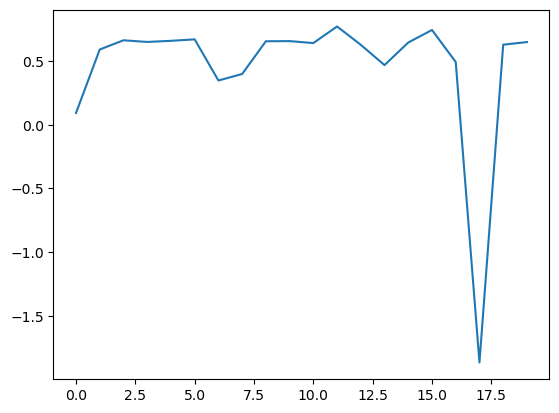

In [212]:
plt.plot(range(len(scores)), scores)

In [213]:
print(np.median(np.array(scores)))
print(np.array(scores).mean())

0.6443586216121107
0.4599671708064147


108479723.35206759


ShapiroResult(statistic=0.5204606056213379, pvalue=0.0)

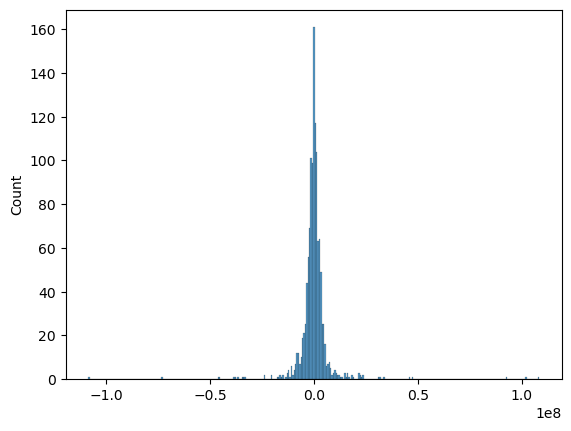

In [214]:
print(results.resid.max())

sns.histplot(results.resid)

shapiro(results.resid)

## Simplification des Quartiers

In [215]:
df = pd.read_csv(folder+'data_tab.csv', index_col=0)
df.head()

,Quartier,AgeBatiment,NombreUtilisations,PremierTypePropriete,NombreBatiments,NombreEtages,SurfacePlancherTotal,SurfaceTotaleParking,SurfaceTotaleHorsParking,ListeUtilisationsBatiment,UtilisationPrincipale,SurfaceUtilisationPrincipale,UtilisationSecondaire,SurfaceUtilisationSecondaire,UtilisationTertiaire,SurfaceUtilisationTertiaire,Conformité,ConsoSite/S(kBtu/sf),ConsoSiteNorm/S(kBtu/sf),ConsoSource/S(kBtu/sf),ConsoSourceNorm/S(kBtu/sf),ConsoSiteTot(kBtu),ConsoSiteTotNorm(kBtu),Vapeur(kBtu),Électricité(kBtu),GazNaturel(kBtu),EmissionGES,IntensiteGES/S,TrancheAge,Pertes/S(kBtu/sf),ProportionVapeur,ProportionElectricité,ProportionGazNaturel,Latitude,Longitude
0,DOWNTOWN,89,1,Hotel,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Aucune,0.0,Aucune,0.0,Compliant,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,249.98,2.83,"[87,116[",100.800003,0.277302,0.546060,0.176638,47.61220,-122.33799
1,DOWNTOWN,20,3,Hotel,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,Compliant,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,295.86,2.86,"[0,29[",81.300003,0.000000,0.386609,0.613391,47.61317,-122.33393
2,DOWNTOWN,47,1,Hotel,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Aucune,0.0,Aucune,0.0,Compliant,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,2.19,"[29,58[",145.899994,0.297113,0.682307,0.020579,47.61393,-122.33810
3,DOWNTOWN,90,1,Hotel,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Aucune,0.0,Aucune,0.0,Compliant,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,286.43,4.67,"[87,116[",105.399994,0.325913,0.407519,0.266567,47.61412,-122.33664
4,DOWNTOWN,36,3,Hotel,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,Compliant,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,505.01,2.88,"[29,58[",96.599991,0.000000,0.378802,0.621198,47.61375,-122.34047


In [216]:
def zone(latitude):
    if latitude < 47.5908 :
        return 'Sud'
    if (latitude >= 47.5908) & (latitude < 47.6441) :
        return 'Centre'
    if latitude >= 47.6441 :
        return 'Nord'

In [217]:
df['Zone'] = df['Latitude'].apply(zone)

In [218]:
df.head()

,Quartier,AgeBatiment,NombreUtilisations,PremierTypePropriete,NombreBatiments,NombreEtages,SurfacePlancherTotal,SurfaceTotaleParking,SurfaceTotaleHorsParking,ListeUtilisationsBatiment,UtilisationPrincipale,SurfaceUtilisationPrincipale,UtilisationSecondaire,SurfaceUtilisationSecondaire,UtilisationTertiaire,SurfaceUtilisationTertiaire,Conformité,ConsoSite/S(kBtu/sf),ConsoSiteNorm/S(kBtu/sf),ConsoSource/S(kBtu/sf),ConsoSourceNorm/S(kBtu/sf),ConsoSiteTot(kBtu),ConsoSiteTotNorm(kBtu),Vapeur(kBtu),Électricité(kBtu),GazNaturel(kBtu),EmissionGES,IntensiteGES/S,TrancheAge,Pertes/S(kBtu/sf),ProportionVapeur,ProportionElectricité,ProportionGazNaturel,Latitude,Longitude,Zone
0,DOWNTOWN,89,1,Hotel,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Aucune,0.0,Aucune,0.0,Compliant,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,249.98,2.83,"[87,116[",100.800003,0.277302,0.546060,0.176638,47.61220,-122.33799,Centre
1,DOWNTOWN,20,3,Hotel,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,Compliant,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,295.86,2.86,"[0,29[",81.300003,0.000000,0.386609,0.613391,47.61317,-122.33393,Centre
2,DOWNTOWN,47,1,Hotel,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Aucune,0.0,Aucune,0.0,Compliant,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,2.19,"[29,58[",145.899994,0.297113,0.682307,0.020579,47.61393,-122.33810,Centre
3,DOWNTOWN,90,1,Hotel,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Aucune,0.0,Aucune,0.0,Compliant,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,286.43,4.67,"[87,116[",105.399994,0.325913,0.407519,0.266567,47.61412,-122.33664,Centre
4,DOWNTOWN,36,3,Hotel,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,Compliant,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,505.01,2.88,"[29,58[",96.599991,0.000000,0.378802,0.621198,47.61375,-122.34047,Centre


In [219]:
data2 = df[['Zone', 'NombreUtilisations', 'NombreBatiments', 'NombreEtages',
       'PremierTypePropriete', 'SurfacePlancherTotal', 'Conformité',
       'ConsoSite/S(kBtu/sf)', 'AgeBatiment']]
data2.head()

,Zone,NombreUtilisations,NombreBatiments,NombreEtages,PremierTypePropriete,SurfacePlancherTotal,Conformité,ConsoSite/S(kBtu/sf),AgeBatiment
0,Centre,1,1.0,12,Hotel,88434,Compliant,81.699997,89
1,Centre,3,1.0,11,Hotel,103566,Compliant,94.800003,20
2,Centre,1,1.0,41,Hotel,956110,Compliant,96.000000,47
3,Centre,1,1.0,10,Hotel,61320,Compliant,110.800003,90
4,Centre,3,1.0,18,Hotel,175580,Compliant,114.800003,36


In [220]:
data2.PremierTypePropriete.unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'K-12 School', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Low-Rise Multifamily', 'Restaurant'],
      dtype=object)

# Clustering

In [221]:
data2.columns

Index(['Zone', 'NombreUtilisations', 'NombreBatiments', 'NombreEtages',
       'PremierTypePropriete', 'SurfacePlancherTotal', 'Conformité',
       'ConsoSite/S(kBtu/sf)', 'AgeBatiment'],
      dtype='object')

In [222]:
scaler = StandardScaler()

df_kmeans = pd.DataFrame(scaler.fit_transform(data2[['SurfacePlancherTotal', 'ConsoSite/S(kBtu/sf)', 'AgeBatiment']]),
             columns=['SurfacePlancherTotal', 'ConsoSite/S(kBtu/sf)', 'AgeBatiment'],
            index=data2.index)
df_kmeans.head()

,SurfacePlancherTotal,ConsoSite/S(kBtu/sf),AgeBatiment
0,-0.123578,0.096734,1.040599
1,-0.043840,0.269957,-1.057479
2,4.448641,0.285825,-0.236492
3,-0.266455,0.481527,1.071006
4,0.335638,0.534420,-0.570968


In [223]:
X_scaled = df_kmeans.values

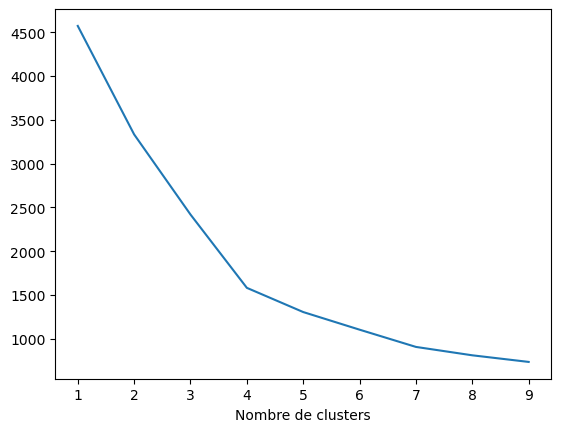

In [224]:
# méthode du coude pour déterminer le nombre de clusters le plus pertinents
# on standardise les données au préalable
warnings.simplefilter('ignore')

liste_clusters = []

for n in range(1,10):
    kmeans = KMeans(n_clusters=n, random_state=1)
    kmeans.fit(X_scaled)
    liste_clusters.append(kmeans.inertia_)

plt.plot(range(1,10), liste_clusters)
plt.xlabel('Nombre de clusters');

In [225]:
# création de l'estimateur

kmeans = KMeans(n_clusters=4, random_state=1)

kmeans.fit(X_scaled)

KMeans(n_clusters=4, random_state=1)

In [226]:
# coordonnées des centroides

centroides = kmeans.cluster_centers_

In [227]:
# clusters de l'echantillon

clusters_kmeans = kmeans.labels_
df['clusters_kmeans']=clusters_kmeans
data2['clusters_kmeans']=clusters_kmeans

In [228]:
df.to_csv(folder+'data_tab_clusters.csv')

In [229]:
data2

,Zone,NombreUtilisations,NombreBatiments,NombreEtages,PremierTypePropriete,SurfacePlancherTotal,Conformité,ConsoSite/S(kBtu/sf),AgeBatiment,clusters_kmeans
0,Centre,1,1.0,12,Hotel,88434,Compliant,81.699997,89,0
1,Centre,3,1.0,11,Hotel,103566,Compliant,94.800003,20,1
2,Centre,1,1.0,41,Hotel,956110,Compliant,96.000000,47,3
3,Centre,1,1.0,10,Hotel,61320,Compliant,110.800003,90,0
4,Centre,3,1.0,18,Hotel,175580,Compliant,114.800003,36,1
...,...,...,...,...,...,...,...,...,...,...
3370,Sud,1,1.0,1,Other,18261,Compliant,51.000000,34,1
3372,Centre,1,1.0,1,Other,16000,Compliant,59.400002,12,1
3373,Centre,3,1.0,1,Other,13157,Compliant,438.200012,42,2
3374,Sud,5,1.0,1,Mixed Use Property,14101,Compliant,51.000000,27,1


In [230]:
df0 = data2[data2['clusters_kmeans']==0]
df1 = data2[data2['clusters_kmeans']==1]
df2 = data2[data2['clusters_kmeans']==2]
df3 = data2[data2['clusters_kmeans']==3]
df12 = df[df['UtilisationPrincipale']=='Social/Meeting Hall']

liste_df = [df0, df1, df2, df3]

In [231]:
for df in liste_df:
    print(f"df{df['clusters_kmeans'].unique()[0]}")
    print('surface :',df['SurfacePlancherTotal'].mean())
    print('conso :',df['ConsoSite/S(kBtu/sf)'].mean())
    print('age :',df['AgeBatiment'].mean())
    print('_'*100)

print(f"df12")
print('surface :',df12['SurfacePlancherTotal'].mean())
print('conso :',df12['ConsoSite/S(kBtu/sf)'].mean())
print('age :',df12['AgeBatiment'].mean())

df0
surface : 63976.83210332103
conso : 52.63542435859963
age : 91.75645756457564
____________________________________________________________________________________________________
df1
surface : 99171.15731707317
conso : 59.473780452353665
age : 33.9780487804878
____________________________________________________________________________________________________
df2
surface : 95039.15126050421
conso : 277.2722701386554
age : 38.38655462184874
____________________________________________________________________________________________________
df3
surface : 1004840.9534883721
conso : 71.38604625372093
age : 30.674418604651162
____________________________________________________________________________________________________
df12
surface : 33837.0
conso : 87.370000171
age : 77.4


cluster 0 :  
petite surface
conso m² faible
vieux batiment

cluster 1 :  
surface moyenne +
conso m² faible
batiment plutot recent

cluster 2 :  
surface moyenne +
conso m² forte
batiment plutot recent

cluster 3 :  
surface énorme
conso m² moyenne
batiment plutot recent

## Simplification type utilisation

In [234]:
data2['PremierTypePropriete'].value_counts()

Small- and Mid-Sized Office    288
Other                          238
Warehouse                      185
Large Office                   170
Mixed Use Property             109
Retail Store                    86
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     39
Medical Office                  39
K-12 School                     39
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Hospital                        10
Laboratory                      10
Restaurant                      10
Low-Rise Multifamily             2
Name: PremierTypePropriete, dtype: int64

In [235]:
office = ['Small- and Mid-Sized Office', 'Large Office']
medical = ['Medical Office', 'Hospital', 'Laboratory', 'Senior Care Community']
consommation = ['Retail Store', 'Distribution Center', 'Supermarket / Grocery Store']
industriel = ['Warehouse', 'Self-Storage Facility', 'Refrigerated Warehouse']
universite = ['K-12 School', 'Residence Hall', 'University']
detente = ['Hotel', 'Restaurant']
other = ['Other', 'Mixed Use Property', 'Worship Facility', 'Low-Rise Multifamily']

In [242]:
def new_utilisation(value):
    if value in office : return 'Bureau'
    if value in medical : return 'Médical'
    if value in consommation : return 'Supermarché'
    if value in industriel : return 'Industriel'
    if value in universite : return 'Universitaire'
    if value in detente : return 'Détente'
    if value in other : return 'Autre'

In [245]:
data2['Utilisation'] = data2['PremierTypePropriete'].apply(new_utilisation)

# Nouvelle Iteration

In [250]:
df_new = data2[['Zone', 'Utilisation', 'Conformité', 'NombreUtilisations',
       'NombreBatiments', 'NombreEtages', 'SurfacePlancherTotal',
       'ConsoSite/S(kBtu/sf)', 'AgeBatiment']]

df_new.head()

,Zone,Utilisation,Conformité,NombreUtilisations,NombreBatiments,NombreEtages,SurfacePlancherTotal,ConsoSite/S(kBtu/sf),AgeBatiment
0,Centre,Détente,Compliant,1,1.0,12,88434,81.699997,89
1,Centre,Détente,Compliant,3,1.0,11,103566,94.800003,20
2,Centre,Détente,Compliant,1,1.0,41,956110,96.000000,47
3,Centre,Détente,Compliant,1,1.0,10,61320,110.800003,90
4,Centre,Détente,Compliant,3,1.0,18,175580,114.800003,36


In [251]:
df_new.to_csv(folder+'df_new.csv')